# Assignment 5: Build and Evaluate Classification Models
Student: Abigail Albury-Bloom
Focus: Multi-class obesity risk classification

## 1. Data loading and basic structure

In [1]:
import pandas as pd, numpy as np
from pathlib import Path

# Expect train.csv and test.csv in the same folder as this notebook
train = pd.read_csv(Path('train.csv'))
test = pd.read_csv(Path('test.csv'))
target = 'NObeyesdad'
X = train.drop(columns=[target, 'id'])
y = train[target]

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Target classes:', y.unique())

Train shape: (20758, 18)
Test shape: (13840, 17)
Target classes: ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


## 2. Class distribution and feature summary

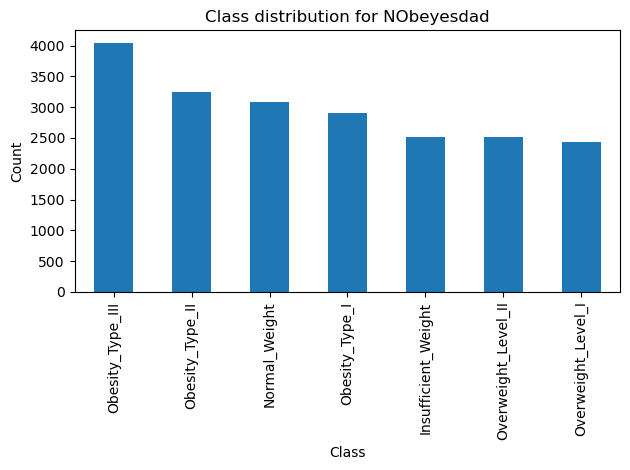

Numeric feature summary:


,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [2]:
import matplotlib.pyplot as plt

plt.figure()
y.value_counts().plot(kind='bar')
plt.title('Class distribution for NObeyesdad')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print('Numeric feature summary:')
display(X.select_dtypes(include=[np.number]).describe().T)

## 3. Feature types and preprocessing pipeline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


## 4. Cross-validated performance for four classifiers

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_models = {
    'Logistic_L2': LogisticRegression(penalty='l2', max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(),
    'GaussianNB': GaussianNB(),
    'SVM_RBF': SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')
}

cv_results = []
for name, clf in base_models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', clf)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    cv_results.append({'Model': name, 'Mean_Accuracy': scores.mean(), 'Std_Accuracy': scores.std()})
    print(f"{name}: {scores.mean():.4f} mean ± {scores.std():.4f} sd")


Logistic_L2: 0.8620 mean ± 0.0046 sd
LDA: 0.8207 mean ± 0.0032 sd
GaussianNB: 0.5874 mean ± 0.0053 sd
SVM_RBF: 0.8788 mean ± 0.0058 sd


## 5. Cross-validated accuracy comparison table

In [5]:
cv_df = pd.DataFrame(cv_results).sort_values(by='Mean_Accuracy', ascending=False).reset_index(drop=True)
display(cv_df)

,Model,Mean_Accuracy,Std_Accuracy
0,SVM_RBF,0.878841,0.005776
1,Logistic_L2,0.862029,0.004608
2,LDA,0.820744,0.003238
3,GaussianNB,0.587388,0.005335


## 6. Holdout validation and confusion matrices


Logistic_L2 holdout accuracy: 0.8683


,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,479,25,0,0,0,1,0
Normal_Weight,58,505,2,0,0,43,9
Obesity_Type_I,1,0,492,37,3,11,38
Obesity_Type_II,0,0,22,625,0,0,3
Obesity_Type_III,0,0,0,1,807,1,0
Overweight_Level_I,1,46,15,0,0,342,81
Overweight_Level_II,0,3,79,8,0,59,355


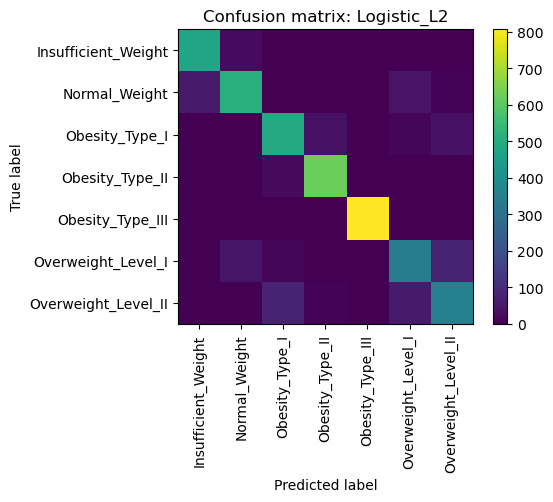


LDA holdout accuracy: 0.8230


,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,470,33,0,0,0,1,1
Normal_Weight,101,442,1,0,0,54,19
Obesity_Type_I,1,1,456,54,7,13,50
Obesity_Type_II,0,0,29,612,5,0,4
Obesity_Type_III,0,0,1,2,805,1,0
Overweight_Level_I,6,74,16,0,0,289,100
Overweight_Level_II,0,9,82,4,0,66,343


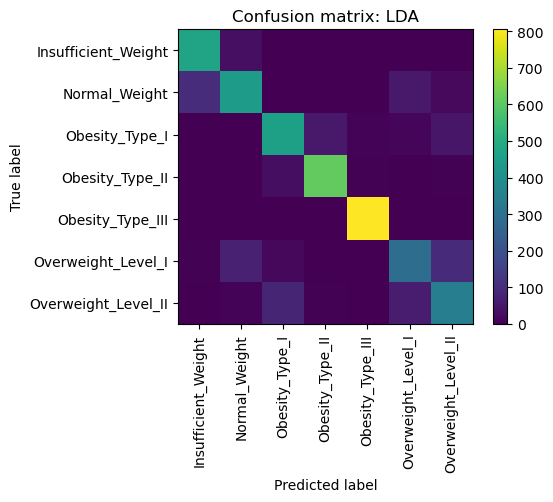


GaussianNB holdout accuracy: 0.5860


,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,377,25,89,4,2,5,3
Normal_Weight,257,123,82,61,17,37,40
Obesity_Type_I,1,17,239,275,5,9,36
Obesity_Type_II,0,2,5,624,0,3,16
Obesity_Type_III,0,1,0,1,806,1,0
Overweight_Level_I,42,53,113,103,9,114,51
Overweight_Level_II,2,29,77,223,1,22,150


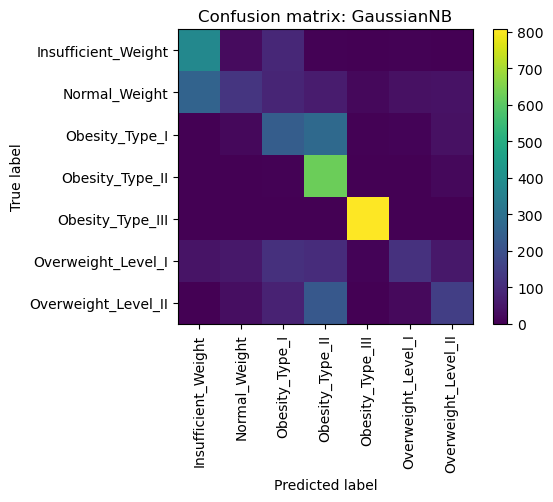


SVM_RBF holdout accuracy: 0.8810


,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,472,32,0,0,0,1,0
Normal_Weight,47,510,1,0,0,51,8
Obesity_Type_I,1,0,513,21,3,12,32
Obesity_Type_II,0,0,19,630,0,0,1
Obesity_Type_III,0,0,2,1,806,0,0
Overweight_Level_I,2,47,18,1,0,340,77
Overweight_Level_II,0,6,47,6,0,58,387


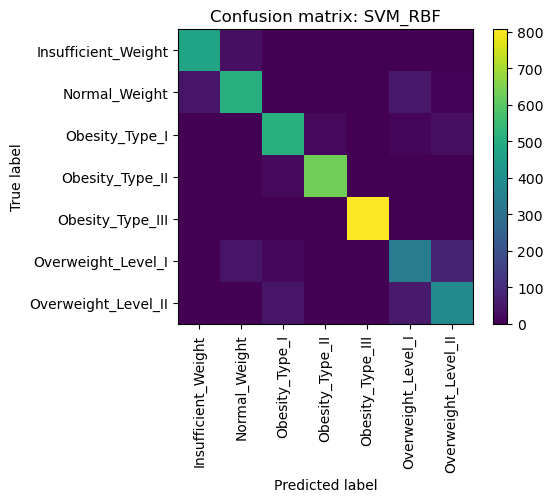

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

validation_results = []
label_order = sorted(y.unique())

for name, clf in base_models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    validation_results.append({'Model': name, 'Holdout_Accuracy': acc})
    print(f"\n{name} holdout accuracy: {acc:.4f}")
    cm = confusion_matrix(y_val, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)
    display(cm_df)

    # Confusion matrix heatmap for visuals
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion matrix: {name}')
    plt.colorbar()
    tick_marks = range(len(label_order))
    plt.xticks(tick_marks, label_order, rotation=90)
    plt.yticks(tick_marks, label_order)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


## 7. Holdout accuracy comparison table

In [7]:
holdout_df = pd.DataFrame(validation_results).sort_values(by='Holdout_Accuracy', ascending=False).reset_index(drop=True)
display(holdout_df)

,Model,Holdout_Accuracy
0,SVM_RBF,0.881021
1,Logistic_L2,0.868256
2,LDA,0.822977
3,GaussianNB,0.585983


## 8. Train final models on full data and generate prediction files

In [8]:
final_predictions = {}
X_test_features = test.drop(columns=['id'])

for name, clf in base_models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', clf)])
    pipe.fit(X, y)
    preds = pipe.predict(X_test_features)
    final_predictions[name] = preds
    out_df = pd.DataFrame({'id': test['id'], target: preds})
    out_name = f'submission_{name}.csv'
    out_df.to_csv(out_name, index=False)
    print(f'Saved {out_name}')


Saved submission_Logistic_L2.csv
Saved submission_LDA.csv
Saved submission_GaussianNB.csv
Saved submission_SVM_RBF.csv


## 1. Data loading and initial structure

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

# Expect train.csv, test.csv, and sample_submission.csv to be in the same folder as this notebook
base_path = Path('.')
train_path = base_path / 'train.csv'
test_path = base_path / 'test.csv'
sample_path = base_path / 'sample_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)

target = 'NObeyesdad'
X = train.drop(columns=[target, 'id'])
y = train[target]

X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation


## 2. Feature types and preprocessing pipeline

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


## 3. Class distribution and numeric correlations

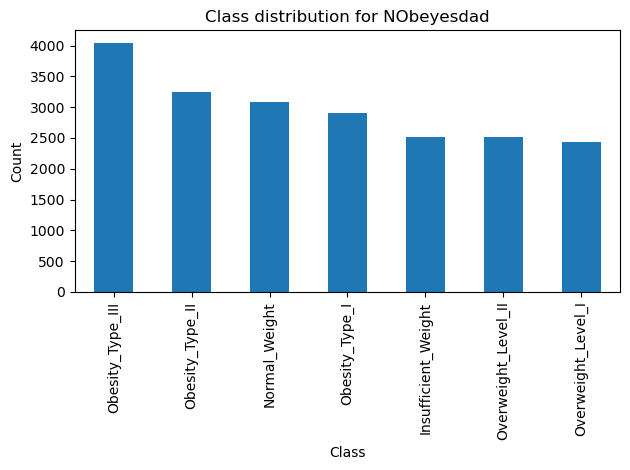

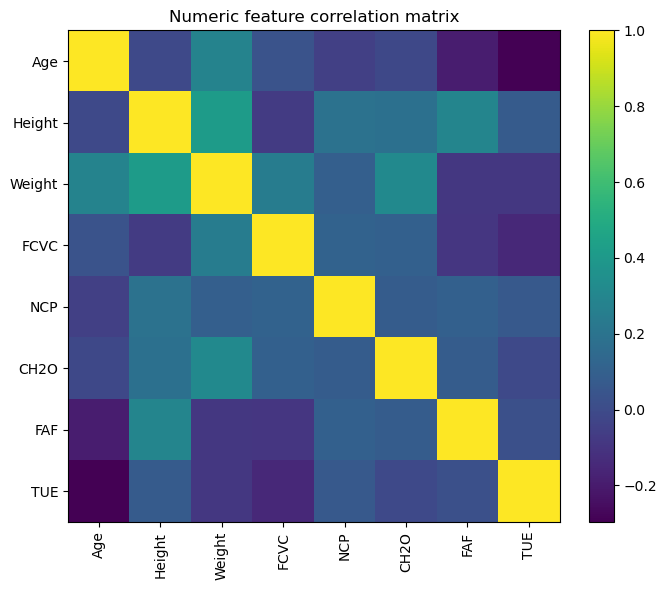

In [11]:
import matplotlib.pyplot as plt

# Class distribution
plt.figure()
train[target].value_counts().plot(kind='bar')
plt.title('Class distribution for NObeyesdad')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features
corr = train[numeric_cols].corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, interpolation='nearest')
plt.title('Numeric feature correlation matrix')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()

## 4. Cross-validated model performance (four classifiers)

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def train_and_eval(name, model):
    pipe = Pipeline([('pre', preprocess), ('clf', model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} mean ± {scores.std():.4f} sd")
    pipe.fit(X, y)
    return pipe

# 1. Multinomial logistic regression with L2 regularization
logit_model = train_and_eval('Multinomial logistic regression (L2)', LogisticRegression(penalty='l2', max_iter=1000))

# 2. Linear Discriminant Analysis
lda_model = train_and_eval('Linear Discriminant Analysis', LinearDiscriminantAnalysis())

# 3. Gaussian Naive Bayes
nb_model = train_and_eval('Gaussian Naive Bayes', GaussianNB())

# 4. Support Vector Machine with RBF kernel
svm_model = train_and_eval('RBF-kernel Support Vector Machine', SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr'))

Multinomial logistic regression (L2): 0.8620 mean ± 0.0046 sd
Linear Discriminant Analysis: 0.8207 mean ± 0.0032 sd
Gaussian Naive Bayes: 0.5874 mean ± 0.0053 sd
RBF-kernel Support Vector Machine: 0.8788 mean ± 0.0058 sd


## 5. Validation split and confusion matrices

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models_for_validation = [
    ('Multinomial logistic regression (L2)', LogisticRegression(penalty='l2', max_iter=1000)),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('RBF-kernel Support Vector Machine', SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr'))
]

for name, clf in models_for_validation:
    pipe = Pipeline([('pre', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"\n{name} validation accuracy: {acc:.4f}")
    cm = confusion_matrix(y_val, preds, labels=sorted(y.unique()))
    cm_df = pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique()))
    print(cm_df)


Multinomial logistic regression (L2) validation accuracy: 0.8683
                     Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Insufficient_Weight                  479             25               0   
Normal_Weight                         58            505               2   
Obesity_Type_I                         1              0             492   
Obesity_Type_II                        0              0              22   
Obesity_Type_III                       0              0               0   
Overweight_Level_I                     1             46              15   
Overweight_Level_II                    0              3              79   

                     Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Insufficient_Weight                0                 0                   1   
Normal_Weight                      0                 0                  43   
Obesity_Type_I                    37                 3                  11   
Obesity_Type_II      

## 6. Generate prediction files for all four models

In [14]:
# Fit each model on the full training data and generate prediction files
logit_pipe = Pipeline([('pre', preprocess), ('clf', LogisticRegression(penalty='l2', max_iter=1000))])
lda_pipe = Pipeline([('pre', preprocess), ('clf', LinearDiscriminantAnalysis())])
nb_pipe = Pipeline([('pre', preprocess), ('clf', GaussianNB())])
svm_pipe = Pipeline([('pre', preprocess), ('clf', SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr'))])

logit_pipe.fit(X, y)
lda_pipe.fit(X, y)
nb_pipe.fit(X, y)
svm_pipe.fit(X, y)

logit_preds = logit_pipe.predict(test.drop(columns=['id']))
lda_preds = lda_pipe.predict(test.drop(columns=['id']))
nb_preds = nb_pipe.predict(test.drop(columns=['id']))
svm_preds = svm_pipe.predict(test.drop(columns=['id']))

pd.DataFrame({'id': test['id'], target: logit_preds}).to_csv('submission_logistic_l2.csv', index=False)
pd.DataFrame({'id': test['id'], target: lda_preds}).to_csv('submission_lda.csv', index=False)
pd.DataFrame({'id': test['id'], target: nb_preds}).to_csv('submission_gaussian_nb.csv', index=False)
pd.DataFrame({'id': test['id'], target: svm_preds}).to_csv('submission_svm_rbf.csv', index=False)

print('Prediction files generated:')
print(' - submission_logistic_l2.csv')
print(' - submission_lda.csv')
print(' - submission_gaussian_nb.csv')
print(' - submission_svm_rbf.csv')

Prediction files generated:
 - submission_logistic_l2.csv
 - submission_lda.csv
 - submission_gaussian_nb.csv
 - submission_svm_rbf.csv
